# <center><u> Final LSTM/GRU Layout - Adri and Elian

# Define Inputs

In [1]:
household = 20
model_name = 'house20_function_tests'
n_input = 144
n_features = 11 
n_output = 72
n_split = 2 * 24 * 324


# Get Household Data

In [2]:
#Import Libraries and Packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import psycopg2
from dotenv import load_dotenv
load_dotenv()

def get_household_data(household):
    #Access Credentials
    db_host = os.getenv("DB_HOST")
    db_name = os.getenv("DB_NAME")
    db_user = os.getenv("DB_USER")
    db_password = os.getenv("DB_PASSWORD")
    db_port = os.getenv("DB_PORT")

    conn = psycopg2.connect(
    host=db_host,
    dbname=db_name,
    user=db_user,
    password=db_password,
    port=db_port
    )

    query=f"""
    select * 
    from agg.tidy_data_final
    where site = {household}
    """

    df = pd.read_sql_query(query, conn)
    df = df.set_index('timestamp', drop=False)
    df = df.sort_index()

    return df
    

# Prepare Data Set for LSTM/GRU Models

In [3]:
from sklearn.preprocessing import MaxAbsScaler
scaler = MaxAbsScaler()

def data_prep(df):
    global n_input 
    global n_features
    global n_output
    global n_split

    # Select features of use for later on
    df_input = df[['net_load', 'precipitation_probability',
                'solar_radiation','sunshine_duration','weekend_or_bank_holiday', 
                    'month', 'day', 'hour', 'day_of_week', 'season', 
                    'avg_net_load',]]
    
    
    variables = ['net_load','solar_radiation','sunshine_duration', 'precipitation_probability', 'avg_net_load' ]


    for var in variables:
        new_var_name = var + '_norm'
        df_input[new_var_name] = scaler.fit_transform(df_input[[var]])

    df_input['sunshine_duration_norm(t+48)'] = df_input['sunshine_duration_norm'].shift(-48) #Add prediction for time the day after
    df_input['solar_radiation_norm(t+48)'] = df_input['solar_radiation_norm'].shift(-48) #Add prediction for time the day after
    df_input['precipitation_probability_norm(t+48)'] = df_input['precipitation_probability_norm'].shift(-48) #Add prediction for time the day after

    df_input.dropna(inplace=True)

    df_input = df_input[['net_load_norm', 'avg_net_load_norm', 'weekend_or_bank_holiday', 'sunshine_duration_norm(t+48)',
               'solar_radiation_norm(t+48)','precipitation_probability_norm(t+48)',
               'month', 'day', 'hour', 'day_of_week', 'season', 
                    ]]
    
    # df_input = df_input[['net_load_norm', 'weekend_or_bank_holiday', 'sunshine_duration_norm(t+48)',
    #         'solar_radiation_norm(t+48)','precipitation_probability_norm(t+48)'
    #             ]]

    X, y = [], []
    for i in range(len(df_input) - n_input - n_output + 1):
        # Select all columns for the input sequence
        X.append(df_input.iloc[i:(i + n_input)].values)  
        
        y.append(df_input['net_load_norm'].iloc[(i + n_input):(i + n_input + n_output)].values)

    X = np.array(X).reshape((len(X), n_input, -1))  
    y = np.array(y)

    X_train = X[:n_split]
    y_train = y[:n_split]

    X_test = X[n_split:]
    y_test = y[n_split:]

    return X_train, y_train, X_test, y_test, df_input

# Build and Fit LSTM/ GRU Models

In [4]:
# Import all Necessary Keras Libraries
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.losses import MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

def build_model(X_train, y_train, model_name):
    model = Sequential()

    model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True ))
    # model.add(BatchNormalization()) 
    model.add(LeakyReLU(alpha=0.01)) 

    model.add(LSTM(32))
    # model.add(BatchNormalization()) 
    model.add(LeakyReLU(alpha=0.01)) 

    model.add(Dropout(0.2))
    model.add(Dense(y_train.shape[1]))

    optimizer = Adam(learning_rate=0.001)

    #Compile Model
    cp1 = ModelCheckpoint(f'{model_name}.keras', save_best_only=True)
    model.compile(loss='mse', optimizer=optimizer,  metrics=[MeanSquaredError(), MeanAbsoluteError()])

    #Fit Model to Training Data with 10% Validation Split
    history = model.fit(X_train, y_train, epochs=10, batch_size=16, validation_split=0.1, callbacks=[cp1])

    return model

# Get Training Outputs

### Evaluation Metrics

In [5]:
def get_train_metrics(model, X_train, y_train):
    _, train_mse, train_mae = model.evaluate(X_train, y_train, verbose=1)

    return train_mse, train_mae

### Visualisation

In [6]:
def get_training_viz(start_section, end_section, df_input, X_train, y_train, model):
    global n_input 
    global n_features
    global n_output
    global n_split



    df_ts_train = df_input[n_input:n_split]

    X_train_shift = X_train[24:]
    y_train_shift = y_train[24:]

    X_train_input = X_train_shift[::48]
    y_train_input = y_train_shift[::48]


    predictions = []

    for i in X_train_input[start_section:end_section]:
        i_reshaped = i.reshape(1, n_input, n_features)

        prediction = model.predict(i_reshaped)

        # We want to omit the first 12 hours the predictions i.e., the non-shaded squares in the figure above.
        prediction_list = list(prediction[0][24:])
        predictions.append(prediction_list)


    y_train_input_24h = []

    for i in y_train_input[start_section:end_section]:
        # i_reshaped = i.reshape(1, n_input, n_features)
        y_train_input_24h.append(i[24:])
        

    plt.figure(figsize=(12,4))
    plt.title(f"Date Range: {df_ts_train.index[start_section*48+48].strftime('%d/%m/%Y')} - {df_ts_train.index[end_section*48+48].strftime('%d/%m/%Y')}")

    # We want to plot the predictions from 00:00 to 00:00 the next day.
    plt.plot(df_ts_train.index[start_section*48+48: end_section*48+48], np.array(predictions).flatten(), label='Prediction')
    plt.plot(df_ts_train.index[start_section*48+48: end_section*48+48], np.array(y_train_input_24h).flatten(), label = 'Actual')
    plt.xlabel('Datetime')
    plt.ylabel('Normalised Net Load (-)')


    # Generate vertical lines for when we predict
    xcoords_DAM = df_ts_train.index[start_section*48+72: (end_section)*48+72][::48]

    for i, xc in enumerate(xcoords_DAM):
        if i == 0:  # First item gets the label
            plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5, label='DAM Gate Closure')
        else:  # Subsequent items do not
            plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5)



    # Generate vertical lines for DAM closure
    xcoords_pred = df_ts_train.index[start_section*48+48: (end_section+1)*48+48][::48]

    for i, xc in enumerate(xcoords_pred):
        if i == 0:  # First item gets the label
            plt.axvline(x=xc, color='purple', linestyle='--', alpha=0.3, label='Energy Delivery Prediction')
        else:  # Subsequent items do not
            plt.axvline(x=xc, color='purple', linestyle='--', alpha=0.3)


    plt.legend(bbox_to_anchor=(0.5, 1.15), loc='center', borderaxespad=0., ncol=4)

# Get Test Outputs

### Evaluation Metrics

In [7]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def get_test_metrics(model, X_test, y_test):
    global n_input 
    global n_features
    global n_output
    global n_split

    X_test_shift = X_test[24:]
    y_test_shift = y_test[24:]

    X_test_input = X_test_shift[::48]
    y_test_input = y_test_shift[::48]

    predictions = []

    for i in X_test_input:
        i_reshaped = i.reshape(1, n_input, n_features)

        prediction = model.predict(i_reshaped)

        # We want to omit the first 12 hours the predictions i.e., the non-shaded squares in the figure above.
        prediction_list = list(prediction[0][24:])
        predictions.append(prediction_list)


    y_test_input_24h = []

    for i in y_test_input:
        # i_reshaped = i.reshape(1, n_input, n_features)
        y_test_input_24h.append(i[24:])

    # Flatten the lists of lists into single lists
    predictions_flat = [item for sublist in predictions for item in sublist]
    y_test_flat = [item for sublist in y_test_input_24h for item in sublist]

    # Calculate MSE
    test_mse = mean_squared_error(y_test_flat, predictions_flat)

    # Calculate MAE
    test_mae = mean_absolute_error(y_test_flat, predictions_flat)

    return test_mse, test_mae

### Visualisation

In [8]:
def get_testing_viz(start_section, end_section, df_input, X_test, y_test, model):
    global n_input 
    global n_features
    global n_output
    global n_split

    df_ts_test = df_input[n_input+n_split:]

    X_test_shift = X_test[24:]
    y_test_shift = y_test[24:]

    X_test_input = X_test_shift[::48]
    y_test_input = y_test_shift[::48]


    predictions = []

    for i in X_test_input[start_section:end_section]:
        i_reshaped = i.reshape(1, n_input, n_features)

        prediction = model.predict(i_reshaped)

        # We want to omit the first 12 hours the predictions i.e., the non-shaded squares in the figure above.
        prediction_list = list(prediction[0][24:])
        predictions.append(prediction_list)


    y_test_input_24h = []

    for i in y_test_input[start_section:end_section]:
        # i_reshaped = i.reshape(1, n_input, n_features)
        y_test_input_24h.append(i[24:])
        

    plt.figure(figsize=(12,4))
    plt.title(f"Date Range: {df_ts_test.index[start_section*48+48].strftime('%d/%m/%Y')} - {df_ts_test.index[end_section*48+48].strftime('%d/%m/%Y')}")

    # We want to plot the predictions from 00:00 to 00:00 the next day.
    plt.plot(df_ts_test.index[start_section*48+48: end_section*48+48], np.array(predictions).flatten(), label='Prediction')
    plt.plot(df_ts_test.index[start_section*48+48: end_section*48+48], np.array(y_test_input_24h).flatten(), label = 'Actual')
    plt.xlabel('Datetime')
    plt.ylabel('Normalised Net Load (-)')


    # Generate vertical lines for when we predict
    xcoords_DAM = df_ts_test.index[start_section*48+72: (end_section)*48+72][::48]

    for i, xc in enumerate(xcoords_DAM):
        if i == 0:  # First item gets the label
            plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5, label='DAM Gate Closure')
        else:  # Subsequent items do not
            plt.axvline(x=xc, color='red', linestyle='--', alpha=0.5)



    # Generate vertical lines for DAM closure
    xcoords_pred = df_ts_test.index[start_section*48+48: (end_section+1)*48+48][::48]

    for i, xc in enumerate(xcoords_pred):
        if i == 0:  # First item gets the label
            plt.axvline(x=xc, color='purple', linestyle='--', alpha=0.3, label='Energy Delivery Prediction')
        else:  # Subsequent items do not
            plt.axvline(x=xc, color='purple', linestyle='--', alpha=0.3)


    plt.legend(bbox_to_anchor=(0.5, 1.15), loc='center', borderaxespad=0., ncol=4)

# Final Workflow

In [9]:
df = get_household_data(household)

C:\Users\elian\AppData\Local\Temp\ipykernel_103852\943468315.py:32: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, conn)


In [10]:
X_train, y_train, X_test, y_test, df_input = data_prep(df)

C:\Users\elian\AppData\Local\Temp\ipykernel_103852\3942465026.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input[new_var_name] = scaler.fit_transform(df_input[[var]])
C:\Users\elian\AppData\Local\Temp\ipykernel_103852\3942465026.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_input[new_var_name] = scaler.fit_transform(df_input[[var]])
C:\Users\elian\AppData\Local\Temp\ipykernel_103852\3942465026.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [ ]:
model = build_model(X_train, y_train, model_name)

In [ ]:
train_mse, train_mae = get_train_metrics(model, X_train, y_train)

In [ ]:
start_section = 0
end_section = 5

get_training_viz(start_section, end_section, df_input, X_train, y_train, model)

In [ ]:
test_mse, test_mae = get_test_metrics(model, X_test, y_test)
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}") 

In [ ]:
start_section = 7
end_section = 14

get_testing_viz(start_section, end_section, df_input, X_test, y_test, model)

# Hyperparameter Tuning

In [11]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.callbacks import ModelCheckpoint
from kerastuner.tuners import RandomSearch

def build_model_hyperparm(hp):
    model = Sequential()

    model.add(LSTM(hp.Int('units_1', min_value=32, max_value=256, step=32),
                   input_shape=(X_train.shape[1], X_train.shape[2]), 
                   return_sequences=hp.Choice('return_sequences', [True, False])))
    model.add(LeakyReLU(alpha=0.01))

    if hp.Choice('return_sequences', [True, False]):
        model.add(LSTM(hp.Int('units_2', min_value=32, max_value=256, step=32)))
        model.add(LeakyReLU(alpha=0.01))

    model.add(Dropout(hp.Float('dropout', min_value=0.1, max_value=0.3, step=0.1)))
    model.add(Dense(y_train.shape[1]))
    
    model.compile(loss='mse', 
                  optimizer=Adam(learning_rate=0.001), 
                  metrics=[MeanSquaredError(), MeanAbsoluteError()])
    
    return model

C:\Users\elian\AppData\Local\Temp\ipykernel_103852\527652936.py:6: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


In [12]:
# Define model checkpoint
cp1 = ModelCheckpoint('tuned_house20_v4.keras', save_best_only=True)

# Initialise Random Search
tuner = RandomSearch(
    build_model_hyperparm,
    objective='val_loss',
    max_trials=5,  
    executions_per_trial=1,  
    directory='model_tuning',
    project_name='house20_v4'
)

# Display search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 4
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
return_sequences (Choice)
{'default': 1, 'conditions': [], 'values': [1, 0], 'ordered': True}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
dropout (Float)
{'default': 0.1, 'conditions': [], 'min_value': 0.1, 'max_value': 0.3, 'step': 0.1, 'sampling': 'linear'}


In [13]:
tuner.search(X_train, y_train, epochs=5, batch_size=16, validation_split=0.1, callbacks=[cp1])

Trial 5 Complete [00h 01m 34s]
val_loss: 0.011826287023723125

Best val_loss So Far: 0.010748842731118202
Total elapsed time: 00h 33m 51s


In [14]:
# Get the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
Optimal Hyperparameters
      1st Layer Units: {best_hps.get('units_1')}
      2nd Layer Units: {best_hps.get('units_2')}
      No. of Layers: {1 if best_hps.get('return_sequences') == 0 else 2 }
      Dropout Rate: {best_hps.get('dropout') }
""")


Optimal Hyperparameters
      1st Layer Units: 224
      2nd Layer Units: 128
      No. of Layers: 2
      Dropout Rate: 0.2



In [15]:
# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

In [16]:
train_mse, train_mae = get_train_metrics(best_model, X_train, y_train)

486/486 [==============================] - 33s 66ms/step - loss: 0.0086 - mean_squared_error: 0.0086 - mean_absolute_error: 0.0609


1/1 [==============================] - 0s 20ms/step


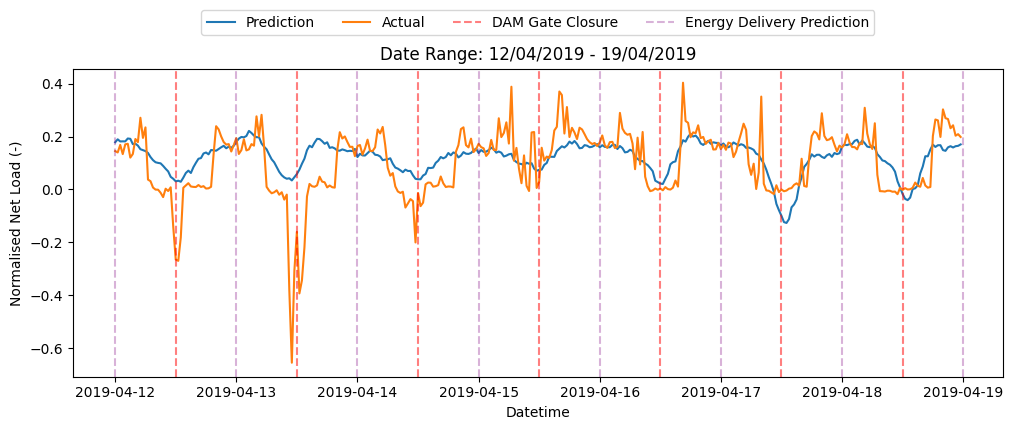

In [17]:
start_section = 7
end_section = 14

get_training_viz(start_section, end_section, df_input, X_test, y_test, best_model)

In [18]:
test_mse, test_mae = get_test_metrics(best_model, X_test, y_test)
print(f"Test MSE: {test_mse}")
print(f"Test MAE: {test_mae}") 

1/1 [==============================] - 0s 25ms/step
Test MSE: 0.023581228910221286
Test MAE: 0.10231169360933058


1/1 [==============================] - 0s 26ms/step


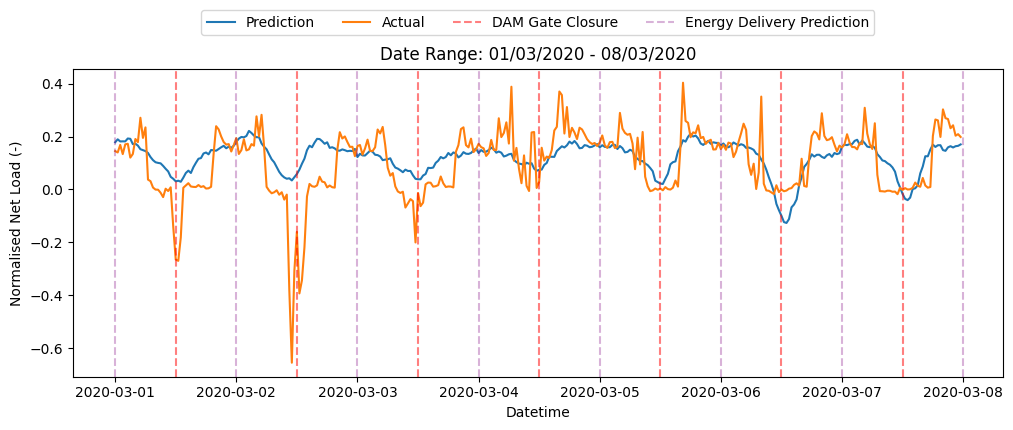

In [19]:
start_section = 7
end_section = 14

get_testing_viz(start_section, end_section, df_input, X_test, y_test, best_model)